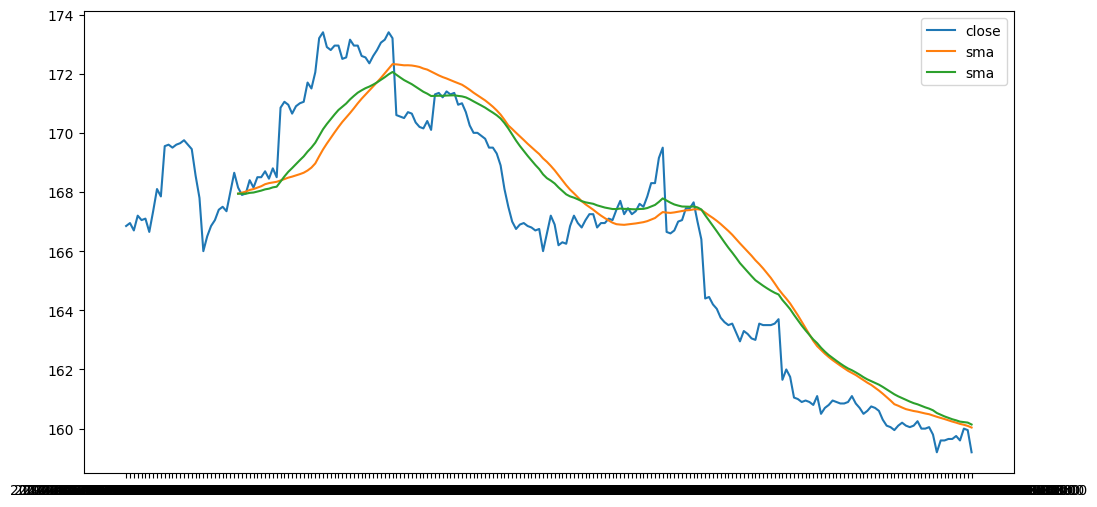

In [1]:
import talib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

a = pd.read_csv('./0050.csv', index_col=0)

sma = talib.SMA(a['close'], 30)
ema = talib.EMA(a["close"], 30)

plt.figure(figsize=(12,6)) 
plt.plot(a["close"], label="close") 
plt.plot(sma,label="sma") 
plt.plot(ema,label="sma") 
plt.legend() 
plt.show()


### 獲得富果API資料讀成CSV格式

In [6]:
import os
from fugle_marketdata import WebSocketClient, RestClient
import pandas as pd

client = RestClient(api_key = os.getenv('FUGLE'))
# print(stock.intraday.quote(symbol="2330"))
stock = client.stock.historical.candles(**{"symbol": "2330", "from": "2023-05-01", "to": "2024-04-30","fields": "open,high,low,close,volume,change,turnover"})

if 'symbol' not in stock:
    raise ValueError(stock['message'])

data = pd.DataFrame(stock['data'])
data.rename(columns={'date': 'datetime'}, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d %H:%M:%S')
data.set_index('datetime', inplace=True)
reversed_df = data.iloc[::-1]
reversed_df.to_csv('2330.csv')

{'date': '2024-08-19',
 'type': 'INDEX',
 'exchange': 'TWSE',
 'isNormal': True,
 'data': [{'symbol': '0051', 'name': '元大中型100'},
  {'symbol': '0053', 'name': '元大電子'},
  {'symbol': '0050', 'name': '元大台灣50'},
  {'symbol': '0061', 'name': '元大寶滬深'},
  {'symbol': '0055', 'name': '元大MSCI金融'},
  {'symbol': '0056', 'name': '元大高股息'},
  {'symbol': '006203', 'name': '元大MSCI台灣'},
  {'symbol': '006204', 'name': '永豐臺灣加權'},
  {'symbol': '006206', 'name': '元大上證50'},
  {'symbol': '006205', 'name': '富邦上証'},
  {'symbol': '0057', 'name': '富邦摩台'},
  {'symbol': '00633L', 'name': '富邦上証正2'},
  {'symbol': '006207', 'name': '復華滬深'},
  {'symbol': '006208', 'name': '富邦台50'},
  {'symbol': '00631L', 'name': '元大台灣50正2'},
  {'symbol': '00625K', 'name': '富邦上証+R'},
  {'symbol': '00636K', 'name': '國泰中國A50+U'},
  {'symbol': '00636', 'name': '國泰中國A50'},
  {'symbol': '00634R', 'name': '富邦上証反1'},
  {'symbol': '00641R', 'name': '富邦日本反1'},
  {'symbol': '00640L', 'name': '富邦日本正2'},
  {'symbol': '00639', 'name': '富邦深100'},
  {

In [2]:
import pandas as pd
pd.read_csv('../2330.csv', index_col=0)

,open,high,low,close,volume,change,turnover
datetime,,,,,,,
2023-05-02 00:00:00,500,502.0,496.5,501.0,17142380,-1.0,8572554842
2023-05-03 00:00:00,496,498.0,495.0,496.0,12694698,-5.0,6305914905
2023-05-04 00:00:00,497,499.5,496.0,498.0,13699933,2.0,6818128036
2023-05-05 00:00:00,500,502.0,498.5,500.0,7898012,2.0,3949232374
2023-05-08 00:00:00,509,509.0,502.0,504.0,11737287,4.0,5932968954
...,...,...,...,...,...,...,...
2024-04-24 00:00:00,770,785.0,769.0,783.0,41652749,29.0,32458429294
2024-04-25 00:00:00,770,774.0,765.0,766.0,30492037,-17.0,23412746667
2024-04-26 00:00:00,788,789.0,782.0,782.0,34721905,16.0,27272338208


### 改寫自定義基礎類別

In [3]:
import backtrader as bt
from datetime import datetime

class ModifyPandasData(bt.feed.DataBase):
    params = (
        ('nocase', True),
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', -1),
    )

    datafields = [
        'datetime', 'open', 'high', 'low', 'close', 'volume', 'openinterest'
    ]

    def __init__(self):
        super(ModifyPandasData, self).__init__()

        # these "colnames" can be strings or numeric types
        colnames = list(self.p.dataname.columns.values)
        
        if self.p.datetime is None:
            # datetime is expected as index col and hence not returned
            pass

        # try to autodetect if all columns are numeric
        cstrings = filter(lambda x: isinstance(x, str), colnames)
        colsnumeric = not len(list(cstrings))

        # Where each datafield find its value
        self._colmapping = dict()

        # Build the column mappings to internal fields in advance
        for datafield in self.getlinealiases():
            defmapping = getattr(self.params, datafield)

            if isinstance(defmapping, int) and defmapping < 0:
                # autodetection requested
                for colname in colnames:
                    if isinstance(colname, str):
                        if self.p.nocase:
                            found = datafield.lower() == colname.lower()
                        else:
                            found = datafield == colname

                        if found:
                            self._colmapping[datafield] = colname
                            break

                if datafield not in self._colmapping:
                    # autodetection requested and not found
                    self._colmapping[datafield] = None
                    continue
            else:
                # all other cases -- used given index
                self._colmapping[datafield] = defmapping

    def start(self):
        super(ModifyPandasData, self).start()

        # reset the length with each start
        self._idx = -1

        # Transform names (valid for .ix) into indices (good for .iloc)
        if self.p.nocase:
            colnames = [x.lower() for x in self.p.dataname.columns.values]
        else:
            colnames = [x for x in self.p.dataname.columns.values]

        for k, v in self._colmapping.items():
            if v is None:
                continue  # special marker for datetime
            if isinstance(v, str):
                try:
                    if self.p.nocase:
                        v = colnames.index(v.lower())
                    else:
                        v = colnames.index(v)
                except ValueError as e:
                    defmap = getattr(self.params, k)
                    if isinstance(defmap, int) and defmap < 0:
                        v = None
                    else:
                        raise e  # let user now something failed

            self._colmapping[k] = v

    def _load(self):
        self._idx += 1

        if self._idx >= len(self.p.dataname):
            # exhausted all rows
            return False

        # Set the standard datafields
        for datafield in self.getlinealiases():
            if datafield == 'datetime':
                continue

            colindex = self._colmapping[datafield]
            if colindex is None:
                # datafield signaled as missing in the stream: skip it
                continue

            # get the line to be set
            line = getattr(self.lines, datafield)

            # indexing for pandas: 1st is colum, then row
            line[0] = self.p.dataname.iloc[self._idx, colindex]

        # datetime conversion
        coldtime = self._colmapping['datetime']
        
        if coldtime is None:
            # standard index in the datetime
            temp = self.p.dataname.index[self._idx]
            tstamp = datetime.strptime(temp, "%Y-%m-%d %H:%M:%S")
        else:
            # it's in a different column ... use standard column index
            temp = self.p.dataname.iloc[self._idx, coldtime]
            tstamp = datetime.strptime(temp, "%Y-%m-%d %H:%M:%S")
            
        # convert to float via datetime and store it
        dt = tstamp
        dtnum = bt.date2num(dt)
        self.lines.datetime[0] = dtnum
        
        # Done ... return
        return True
    
class PandasData_more(ModifyPandasData):
    # 要添加的线
    lines = ('change', 'turnover', )
    # 设置 line 在数据源上的列位置
    params=(
        ('change', -1),
        ('turnover', -1),
    )

### 策略與回測

In [7]:
import backtrader as bt
import pandas as pd
import backtrader.indicators as btind

# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])


class DoubleAverages(bt.Strategy):

    params = (
        ('period_sma10', 10),
        ('period_sma30', 30)
    )
   
    # 打印日志
    def log(self, txt, dt=None):

        dt = dt or self.data.datetime.date(0)
        print('%s, %s' % (dt, txt))

    def __init__(self):
       
        # 用于保存订单
        self.order = None
        # 订单价格
        self.buyprice = None
        # 订单佣金
        self.buycomm = None
       
        # 定义变量保存所有收盘价
        self.dataclose = self.data.close
       
        #计算10日均线
        self.sma10 = btind.MovingAverageSimple(self.dataclose, period=self.params.period_sma10)
        # 计算30日均线
        self.sma30 = btind.MovingAverageSimple(self.dataclose, period=self.params.period_sma30)

    def notify_order(self, order):
       
        # 等待订单提交、订单被cerebro接受
        if order.status in [order.Submitted, order.Accepted]:
            return
       
        # 等待订单完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

            else:
                self.log(
                    'SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
       
        # 如果订单保证金不足，将不会完成，而是执行以下拒绝程序
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):

        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))  # pnl：盈利  pnlcomm：手续费
   
    # 策略逻辑实现
    def next(self):
        
        # 当今天的10日均线大于30日均线并且昨天的10日均线小于30日均线，则进入市场（买）
        if self.sma10[0] > self.sma30[0] and self.sma10[-1] < self.sma30[-1]:
            # 判断订单是否完成，完成则为None，否则为订单信息
            if self.order:
                return
           
            #若上一个订单处理完成，可继续执行买入操作
            self.order = self.buy()
           
        # 当今天的10日均线小于30日均线并且昨天的10日均线大于30日均线，则退出市场（卖）
        elif self.sma10[0] < self.sma30[0] and self.sma10[-1] > self.sma30[-1]:
            # 卖出
            self.order = self.sell()



# 定义Observer
class OrderObserver(bt.observer.Observer):
    lines = ('created', 'expired',)
    # 做图参数设置
    plotinfo = dict(plot=True, subplot=True, plotlinelabels=True)
    # 创建工单 * 标识，过期工单 方块 标识
    plotlines = dict(
        created=dict(marker='*', markersize=8.0, color='lime', fillstyle='full'),
        expired=dict(marker='s', markersize=8.0, color='red', fillstyle='full')
    )

    # 处理 Lines
    def next(self):
        for order in self._owner._orderspending:
            if order.data is not self.data:
                continue

            if not order.isbuy():
                continue

            # Only interested in "buy" orders, because the sell orders
            # in the strategy are Market orders and will be immediately
            # executed

            if order.status in [bt.Order.Accepted, bt.Order.Submitted]:
                self.lines.created[0] = order.created.price

            elif order.status in [bt.Order.Expired]:
                self.lines.expired[0] = order.created.price

# 定义策略
class MACD_KDJStrategy(bt.Strategy):
    # 策略参数
    params = (
        ('highperiod', 9),
        ('lowperiod', 9),
        ('kperiod', 3),
        ('dperiod', 3),
        ('me1period', 12),
        ('me2period', 26),
        ('signalperiod', 9),
        ('limitperc', 1.0), # 限价比例 ，下跌1个百分点才买入，目的可以展示Observer的过期单
        ('valid', 7), # 限价周期
        ('print', False),
        ('counter', 0),  # 计数器
    )

    def log(self, txt, dt=None):
        """ Logging function fot this strategy"""
        dt = dt or self.datas[0].datetime.date(0)
        if self.params.print:
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        # 初始化全局变量，备用
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.volume = self.datas[0].volume

        self.order = None
        self.buyprice = None
        self.buycomm = None

        # N个交易日内最高价
        self.highest = bt.indicators.Highest(self.data.high, period=self.p.highperiod)
        # N个交易日内最低价
        self.lowest = bt.indicators.Lowest(self.data.low, period=self.p.lowperiod)

        # 计算rsv值 RSV=(CLOSE- LOW) / (HIGH-LOW) * 100
        # 如果被除数0 ，为None
        self.rsv = 100 * bt.DivByZero(
            self.data_close - self.lowest, self.highest - self.lowest, zero=None
        )

        # 计算rsv的N个周期加权平均值，即K值
        self.K = bt.indicators.EMA(self.rsv, period=self.p.kperiod, plot=False)
        # D值=K值 的N个周期加权平均值
        self.D = bt.indicators.EMA(self.K, period=self.p.dperiod, plot=False)
        # J=3*K-2*D
        self.J = 3 * self.K - 2 * self.D

        # MACD策略参数
        me1 = bt.indicators.EMA(self.data, period=self.p.me1period, plot=True)
        me2 = bt.indicators.EMA(self.data, period=self.p.me2period, plot=True)

        self.macd = me1 - me2
        self.signal = bt.indicators.EMA(self.macd, period=self.p.signalperiod)
        bt.indicators.MACDHisto(self.data)

    # 订单通知处理
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    "BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (order.executed.price, order.executed.value, order.executed.comm)
                )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.bar_executed_close = self.dataclose[0]
            else:
                self.log(
                    "SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (order.executed.price, order.executed.value, order.executed.comm)
                )
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")

        self.order = None

    # 交易通知处理
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))

    # 策略执行
    def next(self):
        self.log("Close, %.2f" % self.dataclose[0])
        if self.order:
            return

        # 空仓中，开仓买入
        if not self.position:
            # 买入基于MACD策略
            condition1 = self.macd[-1] - self.signal[-1] # 昨天低于signal
            condition2 = self.macd[0] - self.signal[0] # 今天高于signal
            # 买入基于KDJ策略 K值大于D值，K线向上突破D线时，为买进信号。下跌趋势中，K值小于D值，K线向下跌破D线时，为卖出信号。
            condition3 = self.K[-1] - self.D[-1] # 昨天J低于D
            condition4 = self.K[0] - self.D[0]   # 今天J高于D

            if condition1 < 0 and condition2 > 0 and condition3 < 0 and condition4 > 0 :
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                plimit = self.data.close[0] * (1.0 - self.p.limitperc / 100.0)
                valid = self.data.datetime.date(0) + datetime.timedelta(days=self.p.valid)
                self.log('BUY CREATE, %.2f' % plimit)
                # 限价购买
                self.buy(exectype=bt.Order.Limit, price=plimit, valid=valid)


        else:
            # 卖出基于MACD策略
            condition1 = self.macd[-1] - self.signal[-1]
            condition2 = self.macd[0] - self.signal[0]
            # 卖出基于KDJ策略
            condition3 = self.K[-1] - self.D[-1]
            condition4 = self.D[0] - self.D[0]

            if condition1 > 0 and condition2 < 0 and (condition3 > 0 or condition4 < 0):
                self.log("SELL CREATE, %.2f" % self.dataclose[0])
                self.order = self.sell()

    def start(self):
        # 从0 开始
        # self.params.counter += 1
        self.log('Strategy start %s' % self.params.counter)

    def nextstart(self):
        self.params.counter += 1
        self.log('Strategy nextstart %s' % self.params.counter)

    def prenext(self):
        self.params.counter += 1
        self.log('Strategy prenext  %s' % self.params.counter)

    def stop(self):
        self.params.counter += 1
        self.log('Strategy stop  %s' % self.params.counter)
        self.log('Ending Value %.2f' % ( self.broker.getvalue()))

data = PandasData_more(dataname=pd.read_csv('../2330.csv', index_col=0))

cerebro = bt.Cerebro()
cerebro.addstrategy(MACD_KDJStrategy)
cerebro.adddata(data, '2330')
cerebro.broker.set_cash(10000.0) 


cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
strats = cerebro.run()
strat0 = strats[0]
pyfoliozer = strat0.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
print(returns)
returns.index = returns.index.tz_convert(None)
import pandas as pd
import quantstats
quantstats.reports.html(returns, output='stats.html', title='Stock Sentiment')


# print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# cerebro.run()
# print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# cerebro.plot(style="bar", iplot=False)

index
2023-05-02 00:00:00+00:00    0.0
2023-05-03 00:00:00+00:00    0.0
2023-05-04 00:00:00+00:00    0.0
2023-05-05 00:00:00+00:00    0.0
2023-05-08 00:00:00+00:00    0.0
                            ... 
2024-04-24 00:00:00+00:00    0.0
2024-04-25 00:00:00+00:00    0.0
2024-04-26 00:00:00+00:00    0.0
2024-04-29 00:00:00+00:00    0.0
2024-04-30 00:00:00+00:00    0.0
Name: return, Length: 244, dtype: float64


c:\anaconda\envs\stock\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\anaconda\envs\stock\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\anaconda\envs\stock\lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\anaconda\envs\stock\lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\anaconda\envs\stock\lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\anaconda\envs\stock\lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\anaconda\envs\s

In [ ]:
import backtrader as bt
from backtrader import date2num
from datetime import datetime

class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=15)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)


class ShioajiFeeds(bt.feed.DataBase):
    params = (
        ("api_key", os.getenv('FUGLE')),
        ("start", datetime.now().strftime("%Y-%m-%d")),
        ("end", datetime.now().strftime("%Y-%m-%d")),
        ("stock", "2330"),
        ("fields", "open,high,low,close,volume,change,turnover"),
        # 這個變數是 DataBase 的
        # 因為 Shioaji 取得的資料是每分鐘，所以設成 TimeFrame.Minutes
        ("timeframe", bt.TimeFrame.Days)
    )

    def start(self):
        self.client = RestClient(api_key = self.params.api_key)
        
        self.api = sj.Shioaji()
        self.api.login(person_id = self.p.person_id, passwd = self.p.passwd)
        contract = self.api.Contracts.Stocks[self.p.stock]

        self.kbar = self.api.kbars(contract, start = self.p.start, end = self.p.end)

        self.idx = 0
        self.dataLength = len(self.kbar.ts) # 紀錄我們取得的資料有多少筆

    def stop(self):
        pass
        # 結束的時候進行登出
        self.api.logout()
        self.api = None

    def _load(self):
        # 資料會一筆一筆讀進來，如果讀到最後一筆，就跳出 False
        if (self.idx == self.dataLength):
            return False
            
        dt = datetime.utcfromtimestamp(self.kbar.ts[self.idx] / 10**9)
        self.lines.datetime[0] = date2num(dt)
        
        self.lines.open[0] = self.kbar.Open[self.idx]
        self.lines.high[0] = self.kbar.High[self.idx]
        self.lines.low[0] = self.kbar.Low[self.idx]
        self.lines.close[0] = self.kbar.Close[self.idx]
        self.lines.volume[0] = self.kbar.Volume[self.idx]
                
        self.idx += 1
        
        return True
        
        
# 使用自訂的 datafeed
cerebro = bt.Cerebro()

data = ShioajiFeeds(start='2021-10-01', end='2021-10-08', stock='2303')

cerebro.resampledata(data, timeframe=bt.TimeFrame.Days)

cerebro.addstrategy(SmaCross)

cerebro.run()

cerebro.plot()